In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
from functools import partial

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM, step_eps
import jax_dataclasses as jdc
from models.models import MLP, load_model,save_model
#from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2025-02-03 17:39:59.865805: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])
jax.config.update("jax_enable_x64", True)

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
def valid_points(Z,D,Q):
    def cond(point):
        return (point[0]**2+point[1]**2-250**2 <= 0).astype(int)
    z_flat=Z.flatten()
    points=jnp.array([D.flatten(),Q.flatten()]).T
    val_points=jax.vmap(cond,in_axes=0)(points)
    z_flat_val=z_flat*val_points
    return z_flat_val.reshape(D.shape)

def eval_psi_and_L(expert_model):
    fig = plt.figure(figsize=(7,12))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing='ij')
    learned_psi={"Psi_d":expert_model.Psi_d,"Psi_q":expert_model.Psi_q,
                 "L_dd":expert_model.L_dd,"L_dq":expert_model.L_dq,"L_qd":expert_model.L_qd,"L_qq":expert_model.L_qq}

    for  i,name in  zip(range(6),["Psi_d","Psi_q","L_dd","L_dq","L_qd","L_qq"]):
        
        interp=expert_model.motor_env.LUT_interpolators[name]
        Z = interp((D,Q))
        
        Z=Z*1000
        Z=valid_points(Z,D,Q)
        ax = fig.add_subplot(6, 3, 3*i +1, projection='3d')
        norm = plt.Normalize(Z.min(), Z.max())
        colors = cm.viridis(norm(Z))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D,Q, Z, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title(name+' in mVs - LUT')
        else:
            ax.set_title(name+' in mH - LUT')

        mlp=learned_psi[name]
        z_flatt=jax.vmap(mlp)(jnp.array([D.flatten(),Q.flatten()]).T/expert_model.motor_env.env_properties.physical_constraints.i_d)#
        Z_d=z_flatt.reshape(D.shape)*1000
        
        Z_d=valid_points(Z_d,D,Q)

        ax = fig.add_subplot(6, 3, 3*i +2, projection='3d')
        norm = plt.Normalize(Z_d.min(), Z_d.max())
        colors = cm.viridis(norm(Z_d))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title(name+' in mVs - learned MLP')
        else:
            ax.set_title(name+' in mH - learned MLP')

        Z_difference=jnp.abs(Z - Z_d) #np.abs
        ax = fig.add_subplot(6, 3, 3*i +3, projection='3d')
        norm = plt.Normalize(Z_difference.min(), Z_difference.max())
        colors = cm.viridis(norm(Z_difference))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title('abs. error in mVs')
        else:
            ax.set_title('abs. error in mH')
        ax.ticklabel_format(style='plain')

    fig.show()

def eval_det(expert_model):
    fig = plt.figure(figsize=(12,8))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing='ij')
    def det_gt(i_dq):
        L_dd=motor_env.LUT_interpolators["L_dd"](i_dq)[0]
        L_dq=motor_env.LUT_interpolators["L_dq"](i_dq)[0]
        L_qd=motor_env.LUT_interpolators["L_qd"](i_dq)[0]
        L_qq=motor_env.LUT_interpolators["L_qq"](i_dq)[0]
        mat=jnp.array([[L_dd,L_dq],[L_qd,L_qq]])
        return jnp.linalg.det(mat)

    
    def det_model(i_dq):
        i_dq_norm=i_dq/motor_env.env_properties.physical_constraints.i_d
        mat=expert_model.L_matrix(i_dq_norm)
        return jnp.linalg.det(mat)

    L_det_gt=jax.vmap(det_gt)(jnp.array([D.flatten(),Q.flatten()]).T)#
    L_det_gt=L_det_gt.reshape(D.shape)
    L_det_gt=valid_points(L_det_gt,D,Q)
    L_det_pred=jax.vmap(det_model)(jnp.array([D.flatten(),Q.flatten()]).T)#
    L_det_pred=L_det_pred.reshape(D.shape)
    
    L_det_pred=valid_points(L_det_pred,D,Q)
    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    norm = plt.Normalize(L_det_gt.min(), L_det_gt.max())
    colors = cm.viridis(norm(L_det_gt))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D,Q, L_det_gt, rcount=rcount, ccount=ccount,
                    facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title("det_gt")

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    norm = plt.Normalize(L_det_pred.min(), L_det_pred.max())
    colors = cm.viridis(norm(L_det_pred))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D,Q, L_det_pred, rcount=rcount, ccount=ccount,
                    facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title("det_pred")

    
    Z_difference=jnp.abs(L_det_gt - L_det_pred) #np.abs
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    norm = plt.Normalize(Z_difference.min(), Z_difference.max())
    colors = cm.viridis(norm(Z_difference))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount,
                    facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title('abs. error in mH')
    ax.ticklabel_format(style='plain')

    fig.show()
        

In [5]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_dq_mlp: MLP
    
    def __init__(self,motor_env,psi_layer_sizes,key):
        self.motor_env=motor_env
        key , subkey = jax.random.split(key)
        self.psi_dq_mlp=MLP(psi_layer_sizes,key=subkey,hidden_activation=jax.nn.swish,output_activation=jax.nn.tanh)


    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations
    
    def step(self, obs ,action,tau):
        obs1,_= self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state=self.motor_env.generate_state_from_observation(obs1,self.motor_env.env_properties)
        #obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs,_=self.step_expert(state,action,self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2],obs[4:6]])
    
    @partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm=i_dq/properties.physical_constraints.i_d
                

                p_d["Psi_d"]=self.Psi_d(i_dq_norm)
                p_d["Psi_q"]=self.Psi_q(i_dq_norm)
                p_d["L_dd"]=self.L_dd(i_dq_norm)
                p_d["L_dq"]=self.L_dq(i_dq_norm)
                p_d["L_qd"]=self.L_qd(i_dq_norm)
                p_d["L_qq"]=self.L_qq(i_dq_norm)
            

                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv=jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]

                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array([self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)])[
                0
            ]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    @partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def Psi_d(self,i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[0] #  self.motor_env.LUT_interpolators["Psi_d"](i_dq)[0]  
    def Psi_q(self,i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[1]#   self.motor_env.LUT_interpolators["Psi_q"](i_dq)[0]
    def Psi_d_physical(self,i_dq):
        i_dq_norm=i_dq/self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_d(i_dq_norm) 
    def Psi_q_physical(self,i_dq):
        i_dq_norm=i_dq/self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_q(i_dq_norm)
    def l_d_dq(self,i_dq):
        return jax.grad(self.Psi_d_physical)(i_dq)
    def l_q_dq(self,i_dq):
        return jax.grad(self.Psi_q_physical)(i_dq)
    
    def L_dd(self,i_dq_norm):
        i_dq=i_dq_norm*self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[0]
    def L_dq(self,i_dq_norm):
        i_dq=i_dq_norm*self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[1]
    def L_qd(self,i_dq_norm):
        i_dq=i_dq_norm*self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[0]
    def L_qq(self,i_dq_norm):
        i_dq=i_dq_norm*self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[1]
    
    def L_matrix(self, i_dq):
        L_dd=self.L_dd(i_dq)
        L_dq=self.L_dq(i_dq)
        L_qd=self.L_qd(i_dq)
        L_qq=self.L_qq(i_dq)
        mat=jnp.array([[L_dd,L_dq],[L_qd,L_qq]])
        return mat
    

In [6]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

## Model Learning

In [7]:
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

In [8]:
def featurize_node(obs):
    return obs

In [9]:
import json
with open('model_data/dmpe4.json') as json_data:
    d = json.load(json_data)
long_obs=jnp.array(d["observations"])
long_acts=jnp.array(d["actions"])


def step_eps(eps, omega_el, tau, tau_scale=1.0):
    eps += omega_el * tau * tau_scale
    eps %= 2 * jnp.pi
    boolean = eps > jnp.pi
    summation_mask = boolean * -2 * jnp.pi
    eps = eps + summation_mask
    return eps
eps=[0]
for i in range(long_obs.shape[0]):
    eps.append(step_eps(eps[-1],3*1500 / 60 * 2 * jnp.pi,1e-4))
cos_long_eps=jnp.cos(jnp.array(eps[:-1])[:,None])
sin_long_eps=jnp.sin(jnp.array(eps[:-1])[:,None])
long_obs=jnp.hstack([long_obs,cos_long_eps,sin_long_eps])

long_obs_train=long_obs[:]
long_acts_train=long_acts[:]
# long_obs_val=long_obs[-400:]
# long_acts_val=long_acts[-399:]

In [10]:
from utils.interactions import vmap_rollout_traj_node

In [11]:
def data_gen_single(rng, sequence_len):
    rng, subkey = jax.random.split(rng)
    idx = jax.random.randint(subkey, shape=(1,),minval=0, maxval=(long_obs_train.shape[0]-sequence_len-1))

    slice = jnp.linspace(
            start=idx, stop=idx + sequence_len, num=sequence_len+1, dtype=int
        ).T
    act_slice = jnp.linspace(
            start=idx, stop=idx + sequence_len-1, num=sequence_len, dtype=int
        ).T
    
    obs=long_obs_train[slice][0]
    acts=long_acts_train[act_slice][0]
    return obs,acts,rng

In [12]:
def val_function(model_state,rng):
    eval_psi_and_L(model_state)
    plt.show()
    val_loss=0
    terminate_learning=False
    return val_loss, terminate_learning

In [13]:
def L_det_pred(model,obs):
    i_dq_norm=jnp.array([obs[0]*0.5-0.5,obs[1]])
    L_mat=model.L_matrix(i_dq_norm)
    return jnp.linalg.det(L_mat)

In [14]:
def L_dd(model,obs):
    i_dq_norm=jnp.array([obs[0]*0.5-0.5,obs[1]])
    L_dd=model.L_dd(i_dq_norm)
    return L_dd

In [15]:
def L_qq(model,obs):
    i_dq_norm=jnp.array([obs[0]*0.5-0.5,obs[1]])
    L_qq=model.L_qq(i_dq_norm)
    return L_qq

In [16]:
@eqx.filter_value_and_grad
def grad_loss(model, true_obs, actions, tau, featurize):

    feat_pred_obs = vmap_rollout_traj_node(model, featurize, true_obs[:, 0, :], actions, tau)
    # create vmap_rollout_traj_node

    feat_true_obs = jax.vmap(jax.vmap(featurize, in_axes=(0)), in_axes=(0))(true_obs)
    # eventually vmap along multiple dimensions (multiple vmaps)

    # positive determinant
    det_pred=jax.vmap(jax.vmap(L_det_pred, in_axes=(None,0)), in_axes=(None,0))(model,feat_pred_obs)
    L_dds= jax.vmap(jax.vmap(L_dd, in_axes=(None,0)), in_axes=(None,0))(model,feat_pred_obs)
    L_qqs= jax.vmap(jax.vmap(L_qq, in_axes=(None,0)), in_axes=(None,0))(model,feat_pred_obs)
    scaling_det=1e9
    scaling_pos=1e10

    return jnp.mean((feat_pred_obs - feat_true_obs) ** 2)+scaling_det*(jnp.mean(jax.nn.relu(-det_pred)))+scaling_pos*jnp.mean(jax.nn.relu(-L_dds))+scaling_pos*jnp.mean(jax.nn.relu(-L_qqs)) #
    #return jnp.mean((feat_pred_obs - feat_true_obs) ** 2)+scaling_det*(jnp.mean(jax.nn.relu(-det_pred)))+scaling_pos*jnp.mean((0.5*jnp.sign(-L_dds)+0.5)*(jax.nn.relu(-L_dds)+10/scaling_pos))+scaling_pos*jnp.mean((0.5*jnp.sign(-L_qqs)+0.5)*(jax.nn.relu(-L_qqs)+10/scaling_pos)) #

### Learning with variable network sizes

In [17]:
# eqx.tree_serialise_leaves(f"final_models/grey_box/Model_3_3528.eqx",node)
# jax_key = jax.random.PRNGKey(2)
# node_struct=ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,2],key=jax_key)
# node2 = eqx.tree_deserialise_leaves("final_models/grey_box/Model_3_3528.eqx", node_struct)

In [18]:
optimizer_node = optax.adam(1e-4)

In [19]:
batch_size=100
mtrainer=ModelTrainer(
    train_steps=500_000,
    batch_size=batch_size,
    sequence_len=1,
    featurize=featurize_node,
    train_data_gen_sin=data_gen_single,
    validation= val_function,
    model_optimizer=optimizer_node,
    tau= 1e-4,
    loss_func=grad_loss
    )
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))

In [20]:
jax_key = jax.random.PRNGKey(235) 
node = ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,128,2],key=jax_key)
opt_state = optimizer_node.init(node)

  0%|          | 0/500000 [00:00<?, ?it/s]

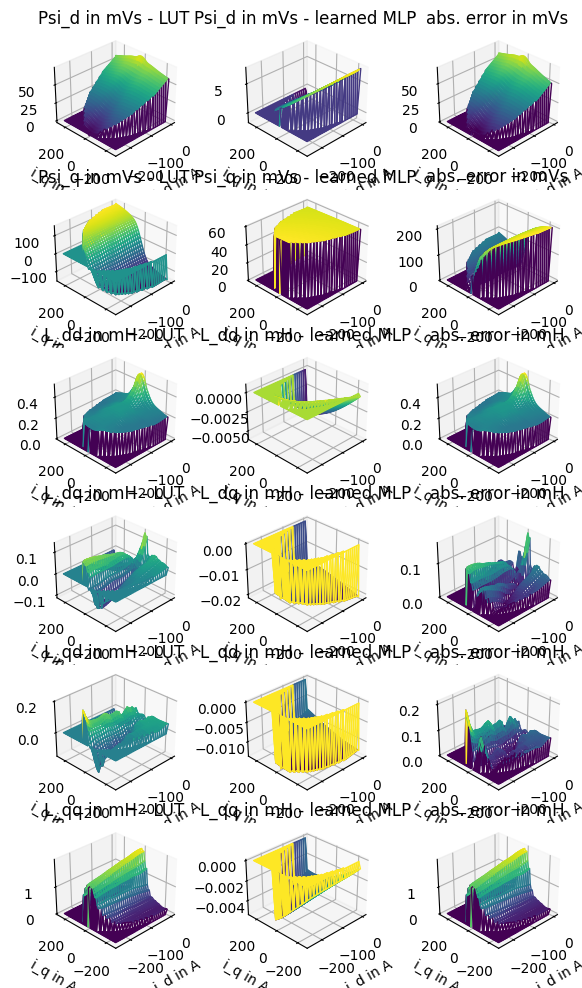

  1%|▏         | 6923/500000 [01:55<2:16:58, 59.99it/s]


KeyboardInterrupt: 

In [21]:
fin_node_big,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit(node,opt_state,keys,validate_every=10_000)
plt.plot(losses)
plt.yscale('log')

In [ ]:
eqx.tree_serialise_leaves(f"final_models/grey_box/Model_4_128.eqx",fin_node_big)

In [ ]:
jax_key = jax.random.PRNGKey(235) 
node = ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,64,64,64,2],key=jax_key)
opt_state = optimizer_node.init(node)

In [ ]:
fin_node_medium,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit(node,opt_state,keys,validate_every=10_000)
plt.plot(losses)
plt.yscale('log')

In [ ]:
eqx.tree_serialise_leaves(f"final_models/grey_box/Model_3_64.eqx",fin_node_medium)

In [ ]:
jax_key = jax.random.PRNGKey(235) 
node = ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,32,32,2],key=jax_key)
opt_state = optimizer_node.init(node)

In [ ]:
fin_node_small,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit(node,opt_state,keys,validate_every=10_000)
plt.plot(losses)
plt.yscale('log')

In [ ]:
eqx.tree_serialise_leaves(f"final_models/grey_box/Model_2_32.eqx",fin_node_small)